# Download Fashion MNIST Data

In [1]:
!mkdir -p ./data/fashion

In [2]:
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -o ./data/fashion/train-labels-idx1-ubyte.gz
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -o ./data/fashion/t10k-images-idx3-ubyte.gz
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -o ./data/fashion/t10k-labels-idx1-ubyte.gz
!curl http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -o ./data/fashion/train-images-idx3-ubyte.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 29515  100 29515    0     0   179k      0 --:--:-- --:--:-- --:--:--  180k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4318k  100 4318k    0     0  7185k      0 --:--:-- --:--:-- --:--:-- 7197k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5148  100  5148    0     0  50431      0 --:--:-- --:--:-- --:--:-- 49980
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.1M  100 25.1M    0     0  24.2M      0  0:00:01  0:00:01 --:--:-- 24.2M


# Import Packages

In [3]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import tensorflow  as tf
from keras.layers import *
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [4]:
from sklearn.utils import shuffle

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Experiment Configuration

In [51]:
batch_size = 128
num_classes = 10
epochs = 100
w_l2 = 1e-4

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# Data Loader function

In [8]:
# https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

## Load Data

In [9]:
x_train, y_train =load_mnist('./data/fashion', kind='train')
x_test, y_test = load_mnist('./data/fashion', kind='t10k')

## Normalize data

In [10]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# Create Mixup Data

In [52]:
len_x_train = x_train.shape[0]

In [65]:
def get_mixup_data(x_train, y_train, alpha=0.1, prob50=False):
    
    x_mixup, y_mixup = shuffle(x_train, y_train)
    
    for i in range(len_x_train):
        lam = np.random.beta(alpha, alpha)
        #rand_idx = np.random.choice(len_x_train)
        x_mixup[i] = (lam * x_mixup[i]) + (1. - lam) * (x_train[i])
        y_mixup[i] = (lam * y_mixup[i]) + (1. - lam) * (y_train[i])
    
    if prob50 is True:
        if np.random.choice([True, False]):
            x_mixup, y_mixup = shuffle(x_train, y_train)
        
    return x_mixup, y_mixup

# Utility functions

In [13]:
def extend_history(hist1, hist2):
    attrs = ['val_acc', 'acc', 'val_loss', 'loss']
    
    for attr in attrs:
        hist1.history[attr].extend(hist2.history[attr])

# Experiment

## 1. ReLU, w/o mixup data augmentation

In [63]:
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [64]:
hist_relu = None

model.optimizer.lr = 1e-3

for _ in range(epochs):
    if (_)%15 == 0:
        if model.optimizer.lr > 3e-5:
            model.optimizer.lr /= 3 
            print ('lr = ' + str(model.optimizer.lr))
        print ('===== Epoch ' + str(_+1) + '/' + str(epochs) + ' =====')
    
    x, y = shuffle(x_train, y_train)
    
    tmp = model.fit(x, y,
          batch_size=batch_size,
          epochs=1,
          verbose=2,
          validation_data=(x_test, y_test))
    
    if hist_relu is None:
        hist_relu = tmp
    else:
        extend_history(hist_relu, tmp)

"""
hist_relu=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
"""

===== Epoch 1/100 =====
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
17s - loss: 0.5241 - acc: 0.8303 - val_loss: 0.6008 - val_acc: 0.8288
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.3561 - acc: 0.8882 - val_loss: 0.3212 - val_acc: 0.8943
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.3116 - acc: 0.9018 - val_loss: 0.2916 - val_acc: 0.9054
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.2843 - acc: 0.9127 - val_loss: 0.2807 - val_acc: 0.9097
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.2671 - acc: 0.9176 - val_loss: 0.2733 - val_acc: 0.9139
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.2500 - acc: 0.9263 - val_loss: 0.2733 - val_acc: 0.9162
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.2374 - acc: 0.9304 - val_loss: 0.3008 - val_acc: 0.9052
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - 

16s - loss: 0.1350 - acc: 0.9820 - val_loss: 0.3525 - val_acc: 0.9296
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1356 - acc: 0.9817 - val_loss: 0.3775 - val_acc: 0.9268
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1343 - acc: 0.9822 - val_loss: 0.3755 - val_acc: 0.9276
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1340 - acc: 0.9821 - val_loss: 0.3641 - val_acc: 0.9289
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1327 - acc: 0.9829 - val_loss: 0.3845 - val_acc: 0.9269
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1338 - acc: 0.9828 - val_loss: 0.3628 - val_acc: 0.9262
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1353 - acc: 0.9823 - val_loss: 0.3476 - val_acc: 0.9281
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1352 - acc: 0.9828 - val_loss: 0.3859 - val_acc: 0.9263
Train on 60000 sampl

"\nhist_relu=model.fit(x_train, y_train,\n          batch_size=batch_size,\n          epochs=epochs,\n          verbose=2,\n          validation_data=(x_test, y_test), callbacks=[reduce_lr])\nscore = model.evaluate(x_test, y_test, verbose=0)\nprint('Test loss:', score[0])\nprint('Test accuracy:', score[1])\n"

## 2. ReLU, w/ mixup data augmentation

In [61]:
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [62]:
hist_relu_mixup = None

model.optimizer.lr = 1e-3

for _ in range(epochs):
    if (_)%15 == 0:
        if model.optimizer.lr > 3e-5:
            model.optimizer.lr /= 3  
            print ('lr = ' + str(model.optimizer.lr))
        print ('===== Epoch ' + str(_+1) + '/' + str(epochs) + ' =====')
    
    x_train_mixup, y_train_mixup = get_mixup_data(x_train, y_train)
    
    tmp = model.fit(x_train_mixup, y_train_mixup,
          batch_size=batch_size,
          epochs=1,
          verbose=2,
          validation_data=(x_test, y_test))
    
    if hist_relu_mixup is None:
        hist_relu_mixup = tmp
    else:
        extend_history(hist_relu_mixup, tmp)


"""
hist_relu_mixup=model.fit(x_train_mixup, y_train_mixup,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
"""

===== Epoch 1/100 =====
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
17s - loss: 0.7164 - acc: 0.8107 - val_loss: 0.6394 - val_acc: 0.8726
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.5603 - acc: 0.8649 - val_loss: 0.3391 - val_acc: 0.8946
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.5170 - acc: 0.8817 - val_loss: 0.3052 - val_acc: 0.9030
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.4994 - acc: 0.8858 - val_loss: 0.3053 - val_acc: 0.9009
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.4739 - acc: 0.8948 - val_loss: 0.2849 - val_acc: 0.9135
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.4623 - acc: 0.8992 - val_loss: 0.2802 - val_acc: 0.9147
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.4512 - acc: 0.9030 - val_loss: 0.2752 - val_acc: 0.9195
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - 

16s - loss: 0.3394 - acc: 0.9477 - val_loss: 0.2971 - val_acc: 0.9308
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.3410 - acc: 0.9476 - val_loss: 0.3040 - val_acc: 0.9297
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.3383 - acc: 0.9493 - val_loss: 0.2963 - val_acc: 0.9324
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.3373 - acc: 0.9495 - val_loss: 0.2886 - val_acc: 0.9325
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.3386 - acc: 0.9480 - val_loss: 0.2950 - val_acc: 0.9317
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.3407 - acc: 0.9481 - val_loss: 0.2991 - val_acc: 0.9267
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.3397 - acc: 0.9493 - val_loss: 0.2909 - val_acc: 0.9289
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.3405 - acc: 0.9492 - val_loss: 0.2912 - val_acc: 0.9322
Train on 60000 sampl

"\nhist_relu_mixup=model.fit(x_train_mixup, y_train_mixup,\n          batch_size=batch_size,\n          epochs=epochs,\n          verbose=2,\n          validation_data=(x_test, y_test), callbacks=[reduce_lr])\nscore = model.evaluate(x_test, y_test, verbose=0)\nprint('Test loss:', score[0])\nprint('Test accuracy:', score[1])\n"

## 3. ReLU w/ 50% Mixup

In [66]:
img_rows, img_cols = 28, 28

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),  kernel_regularizer=regularizers.l2(w_l2),
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3),  kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(w_l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [67]:
hist_relu_mixup2 = None

model.optimizer.lr = 1e-3

for _ in range(epochs):
    if (_)%15 == 0:
        if model.optimizer.lr > 3e-5:
            model.optimizer.lr /= 3 
            print ('lr = ' + str(model.optimizer.lr))
        print ('===== Epoch ' + str(_+1) + '/' + str(epochs) + ' =====')
    
    x_train_mixup2, y_train_mixup2 = get_mixup_data(x_train, y_train, prob50=True)
    
    tmp = model.fit(x_train_mixup2, y_train_mixup2,
          batch_size=batch_size,
          epochs=1,
          verbose=2,
          validation_data=(x_test, y_test))
    
    if hist_relu_mixup2 is None:
        hist_relu_mixup2 = tmp
    else:
        extend_history(hist_relu_mixup2, tmp)


"""
hist_relu_mixup2=model.fit(x_train_mixup2, y_train_mixup2,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[reduce_lr])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
"""

===== Epoch 1/100 =====
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
17s - loss: 0.5287 - acc: 0.8317 - val_loss: 0.5530 - val_acc: 0.8513
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.3605 - acc: 0.8858 - val_loss: 0.3084 - val_acc: 0.9017
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
17s - loss: 0.3144 - acc: 0.9020 - val_loss: 0.2907 - val_acc: 0.9095
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.5202 - acc: 0.8877 - val_loss: 0.2857 - val_acc: 0.9144
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.4906 - acc: 0.8933 - val_loss: 0.3034 - val_acc: 0.9052
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.4621 - acc: 0.9028 - val_loss: 0.2818 - val_acc: 0.9150
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.2557 - acc: 0.9258 - val_loss: 0.2821 - val_acc: 0.9152
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - 

16s - loss: 0.3577 - acc: 0.9472 - val_loss: 0.3013 - val_acc: 0.9305
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1356 - acc: 0.9818 - val_loss: 0.3021 - val_acc: 0.9280
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1305 - acc: 0.9826 - val_loss: 0.2966 - val_acc: 0.9311
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1269 - acc: 0.9833 - val_loss: 0.3328 - val_acc: 0.9294
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1249 - acc: 0.9833 - val_loss: 0.3153 - val_acc: 0.9258
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1253 - acc: 0.9831 - val_loss: 0.3072 - val_acc: 0.9274
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1273 - acc: 0.9822 - val_loss: 0.3159 - val_acc: 0.9302
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
16s - loss: 0.1243 - acc: 0.9830 - val_loss: 0.3229 - val_acc: 0.9302
Train on 60000 sampl

"\nhist_relu_mixup2=model.fit(x_train_mixup2, y_train_mixup2,\n          batch_size=batch_size,\n          epochs=epochs,\n          verbose=2,\n          validation_data=(x_test, y_test), callbacks=[reduce_lr])\nscore = model.evaluate(x_test, y_test, verbose=0)\nprint('Test loss:', score[0])\nprint('Test accuracy:', score[1])\n"

# Plot Figure

In [49]:
def plot_history(hists, attribute='val_loss', axis=(-1,41,0.85,0.94), loc='lower right'):
    ylabel = {'oss': 'loss', 'acc': 'accuracy'}
    title = {'val_loss': 'valid. loss', 'loss': 'trn. loss', 'val_acc': 'valid. accuracy', 'acc': 'trn. accuracy'}
    num_hists = len(hists)
    
    plt.figure(figsize=(6, 4))  
    plt.axis(axis)
    for i in range(num_hists):
        plt.plot(hists[i].history[attribute])
    plt.title(title[attribute])  
    plt.ylabel(ylabel[attribute[-3:]])  
    plt.xlabel('epoch')  
    plt.legend(['Default', 'Mixup', "Mixup 50%"], loc=loc)  

    plt.show()

## Mixup alpha=0.1

In [68]:
hists = [hist_relu, hist_relu_mixup, hist_relu_mixup2]

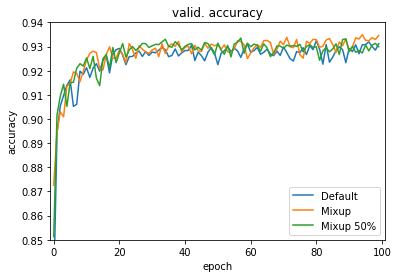

In [74]:
plot_history(hists, attribute='val_acc', axis=(-1,101,0.85,0.94), loc='lower right')
#plt.legend(['Default', 'Mixup', "Mixup 50%", "MMMMMixup 50%"]) 

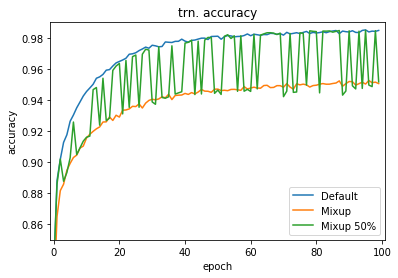

In [70]:
plot_history(hists, attribute='acc', axis=(-1,101,0.85,0.99), loc='lower right')

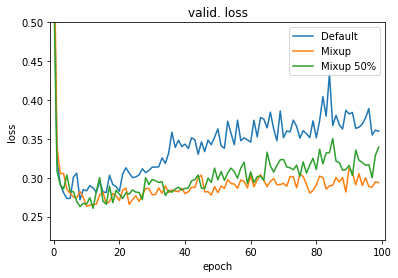

In [71]:
plot_history(hists, attribute='val_loss', axis=(-1,101,0.22,0.5), loc='upper right')

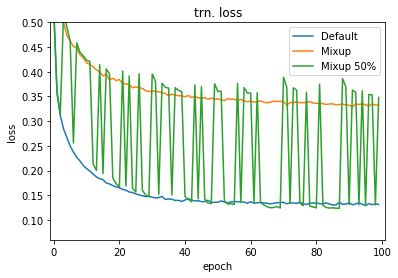

In [72]:
plot_history(hists, attribute='loss', axis=(-1,101,0.06,0.5), loc='upper right')